In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

import pyrosetta
import pyrosetta.rosetta as rosetta
from pyrosetta.rosetta import core
import pyrosetta.distributed.viewer as viewer

print('cwd', os.getcwd())

cwd /media/root/hard_disk/test/pyrosetta/pydock


In [2]:
%%file ./my_utils.py
import os
import sys
import shutil
import numpy as np

import pyrosetta
import pyrosetta.rosetta as rosetta
from pyrosetta.rosetta import core
import pyrosetta.distributed.viewer as viewer

def mkdir(path):
    '''
    remove file and create a new one
    '''
    isexist = os.path.exists(path)
    if isexist == True : 
        shutil.rmtree(path)
        os.makedirs(path)
        return True
    else:
        os.makedirs(path)
        return False

def view_pose(pose):
    '''
    cartoon+surface for protein, stick for ligand
    '''
    prot_property = pyrosetta.rosetta.core.chemical.ResidueProperty(3)
    lig_property = pyrosetta.rosetta.core.chemical.ResidueProperty(2)
    metal_property = pyrosetta.rosetta.core.chemical.ResidueProperty(31)
    
    sele_prot = pyrosetta.rosetta.core.select.residue_selector.ResiduePropertySelector(prot_property)
    sele_lig = pyrosetta.rosetta.core.select.residue_selector.ResiduePropertySelector(lig_property)
    sele_metal = pyrosetta.rosetta.core.select.residue_selector.ResiduePropertySelector(metal_property)
    
    view = viewer.init(pose, window_size=(800, 600))
    view.add(viewer.setStyle())
    view.add(viewer.setStyle(residue_selector=sele_prot, command=({'cartoon': {'color':'spectrum'}}))) #spectrum
    #view.add(viewer.setSurface(residue_selector=sele_prot, opacity=0.8, color='white'))
    view.add(viewer.setStyle(residue_selector=sele_lig, command=({'hetflag': True}, {'stick': {'colorscheme': 'brownCarbon'}, 'radius': 0.2})))
    view.add(viewer.setSurface(residue_selector=sele_metal, opacity=1.0, color='red'))
    #view.add(viewer.setHydrogenBonds())
    view.show()

def calculate_ddg(pose_complex, dock_jump, score):
    '''
    calculate ddg
    '''
    pose_forddg = pose_complex.clone()
    score_before = score(pose_forddg)
    move_away = pyrosetta.rosetta.protocols.rigid.RigidBodyTransMover(pose_forddg, dock_jump)
    move_away.step_size(500.0)
    move_away.apply(pose_forddg)
    score_after = score(pose_forddg)
    return score_before - score_after

def get_score_weight(score):
    '''
    get weight of each score
    '''
    score_weight = {}
    for s in range(1, int(core.scoring.end_of_score_type_enumeration) + 1):
        if score.weights()[core.scoring.ScoreType(s)]:
            #print(str(core.scoring.ScoreType(s))+'___'+str(score.weights()[core.scoring.ScoreType(s)]))
            score_weight[core.scoring.ScoreType(s)] = score.weights()[core.scoring.ScoreType(s)]
    return score_weight

def print_dock_score(pose, dock_jump, scorefxn):
    '''
    print_score
    '''
    pose_total_score = scorefxn(pose)
    unweight_energies = pose.energies().total_energies()
    score_dock_weight = get_score_weight(scorefxn)
    #pose_ddg = calculate_ddg(pose, dock_jump, scorefxn)
    pose_ddg = pyrosetta.rosetta.protocols.docking.calc_interaction_energy(pose, scorefxn, pyrosetta.pyrosetta.Vector1([dock_jump]))
    print('='*80)
    print('Total Rosetta Score:{:.2f}'.format(pose_total_score).strip().ljust(40)+'ddg:{:.2f}'.format(pose_ddg).strip().ljust(12))
    print('-'*80) 
    print('energies_type'.ljust(25)+'energies'.ljust(15)+'weight'.ljust(15)+'score'.ljust(15))
    print('-'*80) 
    for key in score_dock_weight.keys():
        print(str(key).split('.')[1].strip().ljust(20)+'{:.2f}'.format(unweight_energies[key]).strip().rjust(12)\
            +'{:.2f}'.format(score_dock_weight[key]).strip().rjust(13)+'{:.2f}'.format(unweight_energies[key]*score_dock_weight[key]).strip().rjust(15))
    print('='*80)

Overwriting ./my_utils.py


In [3]:
from my_utils import *

In [4]:
opts = f"""
-mute all
"""
pyrosetta.distributed.init(opts)

In [5]:
pose = pyrosetta.io.pose_from_file('./test_dock.pdb')
view_pose(pose)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
scorefxn_high = pyrosetta.rosetta.core.scoring.ScoreFunctionFactory.create_score_function('docking')
dock_jump = 1
pyrosetta.rosetta.protocols.docking.setup_foldtree(pose, 'E_I', pyrosetta.pyrosetta.Vector1([dock_jump]))
print_dock_score(pose, dock_jump, scorefxn_high)

Total Rosetta Score:-315.90             ddg:-15.35  
--------------------------------------------------------------------------------
energies_type            energies       weight         score          
--------------------------------------------------------------------------------
fa_atr                  -1731.19         0.34        -585.14
fa_rep                   1131.96         0.04          49.81
fa_sol                    934.37         0.24         226.12
fa_elec                  -366.38         0.03          -9.53
fa_pair                   -33.57         0.16          -5.51
hbond_sr_bb               -47.35         0.24         -11.60
hbond_lr_bb              -105.82         0.24         -25.93
hbond_bb_sc               -25.17         0.24          -6.17
hbond_sc                   -8.74         0.24          -2.14
dslf_ss_dst               -15.29         0.50          -7.65
dslf_cs_ang                 1.10         2.00           2.20
dslf_ss_dih                 0.46         5.

In [7]:
output_file = './output'
mkdir(output_file)

True

In [8]:
%%file ./output/prot_dock.py
import optparse
import os
import time
import pyrosetta

from my_utils import *


class my_docking_protocol():
    def __init__(self, original_pose, dock_jump):
        self.original_pose = original_pose.clone()
        self.dock_jump = dock_jump
        self.scorefxn_low = pyrosetta.rosetta.core.scoring.ScoreFunctionFactory.create_score_function('interchain_cen')
        self.scorefxn_high = pyrosetta.rosetta.core.scoring.ScoreFunctionFactory.create_score_function('docking')
        self.scorefxn_high_min = pyrosetta.rosetta.core.scoring.ScoreFunctionFactory.create_score_function('docking', 'docking_min')
        
    def make_perturb_mover(self, pose, dock_jump, scorefxn_high_min, to_fullatom):
        recover_sidechains = pyrosetta.rosetta.protocols.simple_moves.ReturnSidechainMover(pose)
        randomize_upstream = pyrosetta.rosetta.protocols.rigid.RigidBodyRandomizeMover(pose, dock_jump, pyrosetta.rosetta.protocols.rigid.Partner.partner_upstream)
        randomize_downstream = pyrosetta.rosetta.protocols.rigid.RigidBodyRandomizeMover(pose, dock_jump, pyrosetta.rosetta.protocols.rigid.Partner.partner_downstream) #bugs?
        dock_pert = pyrosetta.rosetta.protocols.rigid.RigidBodyPerturbMover(dock_jump, translation, rotation)
        spin = pyrosetta.rosetta.protocols.rigid.RigidBodySpinMover(dock_jump)
        slide_into_contact = pyrosetta.rosetta.protocols.docking.DockingSlideIntoContact(dock_jump)
        movemap = pyrosetta.rosetta.core.kinematics.MoveMap()
        movemap.set_jump(dock_jump, True)
        minmover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
        minmover.movemap(movemap)
        minmover.score_function(scorefxn_high_min)

        perturb = pyrosetta.rosetta.protocols.moves.SequenceMover()
        perturb.add_mover(randomize_upstream)
        perturb.add_mover(randomize_downstream)  #bugs?
        perturb.add_mover(dock_pert)
        perturb.add_mover(spin)
        perturb.add_mover(slide_into_contact)
        perturb.add_mover(to_fullatom)
        perturb.add_mover(recover_sidechains)
        perturb.add_mover(minmover)

        return perturb

    def make_dock_mover(self, dock_jump, scorefxn_low, scorefxn_high_min):
        dock_prot = pyrosetta.rosetta.protocols.docking.DockingProtocol()
        dock_prot.set_movable_jumps(pyrosetta.Vector1([dock_jump]))
        dock_prot.set_lowres_scorefxn(scorefxn_low)
        dock_prot.set_highres_scorefxn(scorefxn_high_min)
        return dock_prot

    def initialize(self):
        self.to_centroid = pyrosetta.rosetta.protocols.simple_moves.SwitchResidueTypeSetMover('centroid')
        self.to_fullatom = pyrosetta.rosetta.protocols.simple_moves.SwitchResidueTypeSetMover('fa_standard')
        self.perturb = self.make_perturb_mover(self.original_pose, self.dock_jump, self.scorefxn_high_min, self.to_fullatom)
        self.dock_prot = self.make_dock_mover(self.dock_jump, self.scorefxn_low, self.scorefxn_high_min)
        
    def apply(self, pose):
        self.perturb.apply(pose)
        self.dock_prot.apply(pose)
        self.to_fullatom.apply(pose)
    
def docking(pdb_filename, dock_jump, partners, translation=3.0, rotation=8.0, jobs=1, job_output='dock_output'):
    '''
    #protein-protein docking
    '''
    working_dir = os.getcwd()
    output_dir = './output'
    os.chdir(output_dir)
    opts = '-mute all' #'-mute core -mute protocols -mute basic'
    pyrosetta.init(opts)

    original_pose = pyrosetta.io.pose_from_file(pdb_filename)
    pyrosetta.rosetta.protocols.docking.setup_foldtree(original_pose, partners, pyrosetta.pyrosetta.Vector1([dock_jump]))
    my_docking = my_docking_protocol(original_pose, dock_jump)
    my_docking.initialize()

    jd = pyrosetta.toolbox.py_jobdistributor.PyJobDistributor(job_output, jobs, my_docking.scorefxn_high, compress=False)
    jd.native_pose = original_pose
    
    ce_pose = original_pose.clone()
    my_docking.to_centroid.apply(ce_pose)
    
    counter = 1
    while not jd.job_complete:
        #print(jd.__dict__)
        cur_id = jd.current_name
        try:
            '''
            preset
            '''
            dock_pose = ce_pose.clone()
            dock_pose.pdb_info().name(job_output + '_' + str(counter))
            #pyrosetta.rosetta.protocols.moves.AddPyMOLObserver(test_pose, True) #bugs?
            
            '''
            docking
            '''
            my_docking.initialize() #bugs in randomize_downstream?
            my_docking.apply(dock_pose)
            
            '''
            output
            '''
            view_pose(dock_pose)
            ddg = pyrosetta.rosetta.protocols.docking.calc_interaction_energy(dock_pose, my_docking.scorefxn_high, pyrosetta.pyrosetta.Vector1([dock_jump]))
            jd.additional_decoy_info = ddg
            jd.output_decoy(dock_pose)
            print_dock_score(dock_pose, dock_jump, my_docking.scorefxn_high)
            print('finished: {}/{} ({:.2f}%)'.format(counter, jobs, counter/jobs*100))
            counter += 1
        except:
            file_list = os.listdir('./')
            for file_name in file_list:
                if cur_id in file_name:
                    os.remove(file_name)
            print('error occured!')
        
    os.chdir(working_dir)

if __name__ == '__main__':
    parser = optparse.OptionParser()
    parser.add_option('--pdb_filename', dest='pdb_filename', default='../test_dock.pdb', help='the PDB file containing the proteins to dock')
    parser.add_option('--dock_jump', dest='dock_jump', default=1, help='jump splits recepter and ligand')
    parser.add_option('--partners', dest='partners', default='E_I', help='the relative chain partners for docking')
    parser.add_option('--translation', dest='translation', default='3.0', help='magnitude of the random translation applied (in Angstroms)')
    parser.add_option('--rotation', dest='rotation', default='8.0', help='magnitude of the random rotation applied (in degrees)')
    parser.add_option( '--jobs', dest='jobs', default='1', help='the number of jobs (trajectories) to perform')
    parser.add_option( '--job_output', dest='job_output', default='dock_output', help='the name preceding all output, output PDB files and .fasc')
    (options,args) = parser.parse_args()

    pdb_filename = options.pdb_filename
    dock_jump = int(options.dock_jump)
    partners = options.partners
    translation = float(options.translation)
    rotation = float(options.rotation)
    jobs = int(options.jobs)
    job_output = options.job_output

    docking(pdb_filename, dock_jump, partners, translation, rotation, jobs, job_output)

Writing ./output/prot_dock.py


In [9]:
pdb_filename = '../test_dock.pdb'
dock_jump = 1
partners = 'E_I'
translation = 3.0
rotation = 8.0
jobs = 10
job_outputname = 'docking'

if not os.getenv("DEBUG"):
    %run ./output/prot_dock.py \
        --pdb_filename {pdb_filename} \
        --dock_jump {dock_jump} \
        --translation {translation} \
        --rotation {rotation} \
        --jobs {jobs} \
        --job_output {job_outputname}

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Total Rosetta Score:-355.13             ddg:-5.90   
--------------------------------------------------------------------------------
energies_type            energies       weight         score          
--------------------------------------------------------------------------------
fa_atr                  -1652.35         0.34        -558.49
fa_rep                    667.88         0.04          29.39
fa_sol                    873.71         0.24         211.44
fa_elec                  -355.24         0.03          -9.24
fa_pair                   -32.75         0.16          -5.37
hbond_sr_bb               -47.35         0.24         -11.60
hbond_lr_bb              -100.04         0.24         -24.51
hbond_bb_sc               -29.29         0.24          -7.18
hbond_sc                   -8.80         0.24          -2.16
dslf_ss_dst               -15.29         0.50          -7.65
dslf_cs_ang                 1.10         2.00           2.20
dslf_ss_dih                 0.46         5.

In [10]:
print('Done')

Done


In [19]:
sc_file = output_file+'/'+job_outputname+'.fasc'
f = open(sc_file, 'r')
lines = f.readlines()
f.close()

'''
create head columns, set all to np.nan
'''
dic_line0 = eval(lines[0])
cols = list(dic_line0.keys())
df_plot = pd.DataFrame(columns=cols)
for col in cols:
    df_plot[col] = [np.nan]*len(lines)

'''
map score to dataframe
'''
for i in trange(len(lines)):
    dic_line = eval(lines[i])
    for key in dic_line.keys():
        if key=='additional_decoy_info':
            df_plot.loc[i, key] = float(dic_line[key])
        else:
            df_plot.loc[i, key] = dic_line[key]

df_plot = df_plot.rename(columns={'additional_decoy_info':'ddg'})
df_plot

100%|██████████| 10/10 [00:00<00:00, 222.69it/s]


,pdb_name,decoy,filename,nstruct,dslf_ca_dih,dslf_cs_ang,dslf_ss_dih,dslf_ss_dst,fa_atr,fa_dun,...,fa_pair,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,total_score,rmsd,ddg
0,docking,docking_2.pdb,docking_2.pdb,10.0,1.269310,2.200101,2.307995,-7.647096,-554.732073,23.576909,...,-6.055095,30.503775,211.235450,-7.203971,-24.510619,-2.911556,-11.599937,-353.013981,7.162601,-3.786905
1,docking,docking_5.pdb,docking_5.pdb,10.0,1.269310,2.200101,2.307995,-7.647096,-557.566758,23.657096,...,-5.627402,29.471857,212.633818,-6.904085,-24.510619,-2.283844,-11.599937,-353.817174,17.367613,-6.432556
2,docking,docking_4.pdb,docking_4.pdb,10.0,1.269310,2.200101,2.307995,-7.647096,-553.594711,23.766078,...,-5.645937,28.299305,210.244881,-6.779699,-24.510619,-2.335884,-11.599937,-353.155582,10.728861,-2.852742
3,docking,docking_6.pdb,docking_6.pdb,10.0,1.269310,2.200101,2.307995,-7.647096,-553.462832,24.885619,...,-4.958192,45.375020,210.760845,-6.167753,-24.510619,-1.994947,-11.599937,-332.425598,11.173201,-0.595229
4,docking,docking_7.pdb,docking_7.pdb,10.0,1.269310,2.200101,2.307995,-7.647096,-552.272716,25.828092,...,-5.138482,33.469006,212.317088,-6.461311,-24.510619,-2.606996,-11.599937,-342.012153,8.183903,-3.984136
5,docking,docking_3.pdb,docking_3.pdb,10.0,1.691364,49.782887,50.150146,65.481549,-758.985474,402.897787,...,-6.100236,5364.482804,352.425795,-0.118653,-24.510619,-0.621446,-11.599937,5477.800582,8.873575,118.913659
6,docking,docking_8.pdb,docking_8.pdb,10.0,1.269310,2.200101,2.307995,-7.647096,-554.355915,24.456676,...,-5.192953,27.934204,211.165239,-7.014269,-24.510619,-1.901122,-11.599937,-352.109962,10.758599,-2.024169
7,docking,docking_1.pdb,docking_1.pdb,10.0,1.269310,2.200101,2.307995,-7.647096,-555.903171,23.921088,...,-6.474703,30.683942,212.273370,-6.858277,-24.510619,-2.448044,-11.599937,-352.009780,12.646177,-2.350417
8,docking,docking_0.pdb,docking_0.pdb,10.0,1.269310,2.200101,2.307995,-7.647096,-551.818387,24.511020,...,-5.364569,28.091312,209.670145,-6.822117,-24.510619,-2.585257,-11.599937,-351.432429,8.722043,-2.530801
9,docking,docking_9.pdb,docking_9.pdb,10.0,1.269310,2.200101,2.307995,-7.647096,-558.494009,24.458071,...,-5.370818,29.386663,211.437926,-7.176310,-24.510619,-2.156224,-11.599937,-355.131090,4.492968,-5.900619


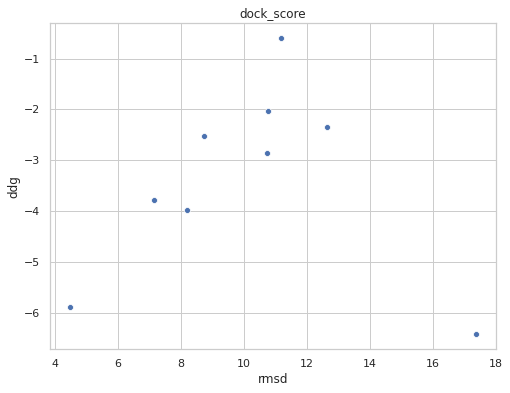

In [20]:
df_filter = df_plot[df_plot['ddg']<10]
df_filter = df_filter[df_filter['rmsd']<30]

sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
plt.title('dock_score')
ax = sns.scatterplot(x='rmsd', y='ddg', data=df_filter)
plt.show()